In [1]:
import os, sys, time
import tifffile as tif
sys.path.append("/home/emilyjanedennis/Desktop/GitHub/rat_BrainPipe")
from tools.utils.io import makedir
from tools.registration.register import change_interpolation_order, transformix_command_line_call
from tools.registration.transform_list_of_points import modify_transform_files
from scipy.ndimage.interpolation import zoom
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv

In [90]:
src = "/home/emilyjanedennis/Desktop/for_registration_to_lightsheet"

fann = os.path.join(src, "output_dirs/SIGMA_fPRA_in_PRA_affine/result.tif")
mann = os.path.join(src, "output_dirs/SIGMA_ann_in_PRA_25/result.tif")

#fann = os.path.join(src, "tiffs/WHS_ann_in_fPRA.tif")
#mann = os.path.join(src, "output_dirs/WHS_ann_in_PRA25/WHS_anns_in_PRA25.tif")

#annotationsfilename=os.path.join(src,"labels/labels_v3.csv")

annotationsfilename = os.path.join(src,"labels/SIGMA_labels.csv")
output= "/home/emilyjanedennis/Desktop/mf_SIGMA.tiff"
percentcsv="/home/emilyjanedennis/Desktop/mf_percent_SIGMA.csv"

## get percent of each brain for a given 'value' or label

In [4]:
# make sure your annotations have the first column as id number, 2nd as abbreviation, or else change the input below
anns=pd.read_csv(annotationsfilename,usecols=[0,1,2],header=0)
print("read annotations")

read annotations


In [5]:
df=anns.dropna()
df

,atlas,ID,label
0,SIGMA,1171,Ventricular System
1,Waxholm,171,Globus Pallidus
2,Waxholm,731,Striatum
3,Waxholm,221,Granule Cell Level of the Cerebellum
4,Waxholm,341,Molecular Layer of the Cerebellum
...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus
230,Waxholm,902,Deeper Layers of the Superior Colliculus
231,Waxholm,1082,SP5
232,Waxholm,792,Anterior Commissure Intrabulbar part


In [6]:
df.insert(3,'fvox',0)
df.insert(4,'mvox',0)


In [92]:
ftiff = tif.imread(fann)
print("read affine tiff")
mtiff = tif.imread(mann)
print(mann)


read affine tiff
/home/emilyjanedennis/Desktop/for_registration_to_lightsheet/output_dirs/SIGMA_ann_in_PRA_25/result.tif


In [8]:
for i in df['ID']:
    df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])
    df.mvox[df.index[df.ID==i]] = np.size(mtiff[mtiff==i])


<ipython-input-8-8efd60b5d6b6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fvox[df.index[df.ID==i]] = np.size(ftiff[ftiff==i])
<ipython-input-8-8efd60b5d6b6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.mvox[df.index[df.ID==i]] = np.size(mtiff[mtiff==i])


In [9]:
df = df[df.mvox > 0]


In [10]:
df

,atlas,ID,label,fvox,mvox
1,Waxholm,171,Globus Pallidus,3265,2844
2,Waxholm,731,Striatum,1813067,1664466
3,Waxholm,221,Granule Cell Level of the Cerebellum,1259382,1265190
4,Waxholm,341,Molecular Layer of the Cerebellum,4238434,4095170
5,Tohoku,31,Amygdalohyppocampic Area,32843,35191
...,...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,3297,2401
230,Waxholm,902,Deeper Layers of the Superior Colliculus,535986,440010
231,Waxholm,1082,SP5,30876,29813
232,Waxholm,792,Anterior Commissure Intrabulbar part,46420,45913


In [11]:
df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
df['mpct'] = (df['mvox']/np.sum(df.mvox))*100
df['fg']= (df['fpct']-df['mpct'])/(df['fpct']+df['mpct'])
df

<ipython-input-11-44d5a020bd85>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fpct'] = (df['fvox']/np.sum(df.fvox))*100
<ipython-input-11-44d5a020bd85>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['mpct'] = (df['mvox']/np.sum(df.mvox))*100
<ipython-input-11-44d5a020bd85>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

,atlas,ID,label,fvox,mvox,fpct,mpct,fg
1,Waxholm,171,Globus Pallidus,3265,2844,0.004364,0.004000,0.043506
2,Waxholm,731,Striatum,1813067,1664466,2.423155,2.340903,0.017265
3,Waxholm,221,Granule Cell Level of the Cerebellum,1259382,1265190,1.683158,1.779362,-0.027784
4,Waxholm,341,Molecular Layer of the Cerebellum,4238434,4095170,5.664646,5.759442,-0.008298
5,Tohoku,31,Amygdalohyppocampic Area,32843,35191,0.043895,0.049493,-0.059945
...,...,...,...,...,...,...,...,...
229,Waxholm,882,Commissure of the Superior Colliculus,3297,2401,0.004406,0.003377,0.132293
230,Waxholm,902,Deeper Layers of the Superior Colliculus,535986,440010,0.716343,0.618829,0.073034
231,Waxholm,1082,SP5,30876,29813,0.041266,0.041929,-0.007973
232,Waxholm,792,Anterior Commissure Intrabulbar part,46420,45913,0.062040,0.064572,-0.019997


In [12]:
df.to_csv(percentcsv)

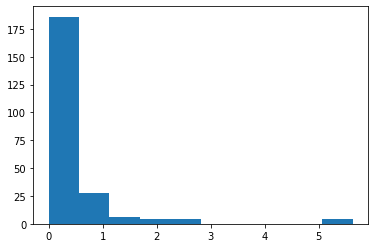

In [13]:
plt.hist(df.fpct-df.mpct/sum(df.fpct,df.mpct),bins=10)
plt.show()

In [70]:
mp = 0
sp = np.nanstd(df.fg)

In [71]:
highmp = mp+sp
highmp
highermp = mp+(2*sp)

In [72]:
lowmp = mp-(0.5*sp)
lowmp
lowermp=mp-(2*sp)

In [17]:
df=pd.read_csv(percentcsv)

In [69]:
mp

-0.0045578046095393135

1162

In [148]:
# want to take IDs and set all to 0 except fg > highmp == 800, fg > higher mp == 1000
# fg < lowmp == 600, fg < lowermp == 500
# then save the tiff
sex_relative = tif.imread(mann)
np.max(sex_relative)

for i in df['ID']:
    if df[df['ID']==i]['fg'].item() >.09:
        sex_relative[sex_relative==i]=1000
    else:
        sex_relative[sex_relative==i]=0

In [149]:
tif.imsave('/home/emilyjanedennis/Desktop/hi_sigma.tif',sex_relative)

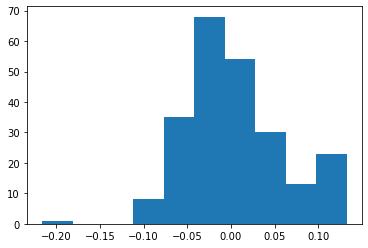

In [104]:
plt.hist(df['fg'])
plt.show()

In [142]:
np.sum(df['fg']<-.06)

24

In [143]:
np.sum(df['fg']>.09)

27

-0.11149420498351735